In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns          
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import gradio as gr

# 1 Data Loading

In [2]:
data=pd.read_csv(r"C:\Users\HP\Downloads\Telegram Desktop\Etho-Agri Dataset.csv")
#data=pd.read_csv(r'C:\Users\hp\Downloads\Telegram Desktop\Etho-Agri Dataset.csv')

In [3]:
data.head()

,Region,crop type,Year,Area cultivated(Ha),Production(kg),Yeild (kg/ha)
0,Tigray,Teff,1996,87880.0,60827000,692
1,Tigray,Barely,1996,87350.0,81711000,935
2,Tigray,Wheat,1996,84550.0,84653000,1001
3,Tigray,Maize,1996,45050.0,67963000,1509
4,Tigray,Sorghum,1996,96140.0,172968000,1799


# 2 Data Preprocessing

### Cleaning And Standardizing Column Names

In [4]:
data.columns = data.columns.str.strip().str.replace(" ", "_").str.replace("(", "").str.replace(")", "") 
# This line is cleaning and standardizing column names in our DataFrame. It uses string functions on each column name.


In [5]:
data.head()

,Region,crop_type,Year,Area_cultivatedHa,Productionkg,Yeild_kg/ha
0,Tigray,Teff,1996,87880.0,60827000,692
1,Tigray,Barely,1996,87350.0,81711000,935
2,Tigray,Wheat,1996,84550.0,84653000,1001
3,Tigray,Maize,1996,45050.0,67963000,1509
4,Tigray,Sorghum,1996,96140.0,172968000,1799


### Check Dataset Shape

In [6]:
data.shape 

(1820, 6)

### Check Null Value

In [7]:
data.isnull().sum()

Region                 0
crop_type              0
Year                   0
Area_cultivatedHa    686
Productionkg           0
Yeild_kg/ha            0
dtype: int64

In [8]:
data[data['crop_type']=='Oats'].isnull().sum()

Region                 0
crop_type              0
Year                   0
Area_cultivatedHa    177
Productionkg           0
Yeild_kg/ha            0
dtype: int64

In [9]:
data[data['crop_type']=='Teff'].isnull().sum()

Region                 0
crop_type              0
Year                   0
Area_cultivatedHa    118
Productionkg           0
Yeild_kg/ha            0
dtype: int64

### Check Duplicated 

In [10]:
data.duplicated().sum()

np.int64(0)

### Adjust  Null Value

In [11]:
#data.dropna(inplace=True)
data['Area_cultivatedHa'].fillna(0,inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_20508\3672410802.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Area_cultivatedHa'].fillna(0,inplace=True)


In [12]:
data.isnull().sum()

Region               0
crop_type            0
Year                 0
Area_cultivatedHa    0
Productionkg         0
Yeild_kg/ha          0
dtype: int64

### Check Outliers

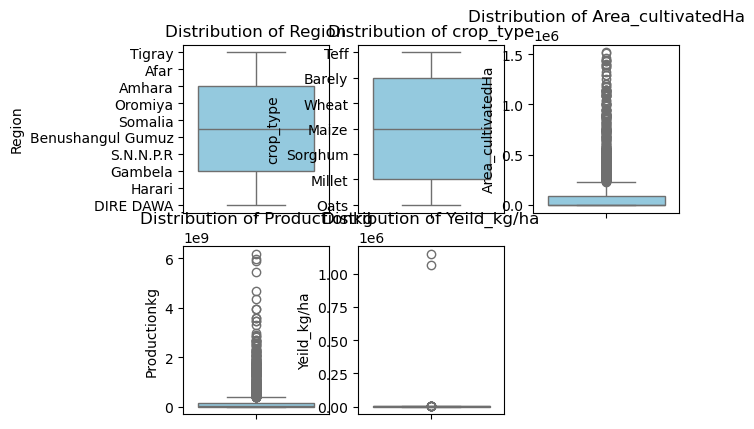

In [13]:
features=['Region', 'crop_type', 'Area_cultivatedHa', 'Productionkg','Yeild_kg/ha']

for i, col in enumerate(features):
    plt.subplot(2,3,i+1)
    sns.boxplot(y=data[col], color='skyblue')
    plt.title(f'Distribution of {col}')


In [14]:
def cap_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data[column] = data[column].clip(lower, upper)
    return data

# Cap outliers for all numeric features
for col in ['Yeild_kg/ha', 'Area_cultivatedHa', 'Productionkg']:
    data = cap_outliers(data, col)


### Why Capping is use ?

 
#### our dealing with real-world crop yield data, where:

##### Some outliers may be valid (e.g., great harvest year).

##### we don’t want to throw away rows unless you're 100% sure the values are invalid.

##### we are training a machine learning model, where extreme values may distort performance.

##### So, using capping Method

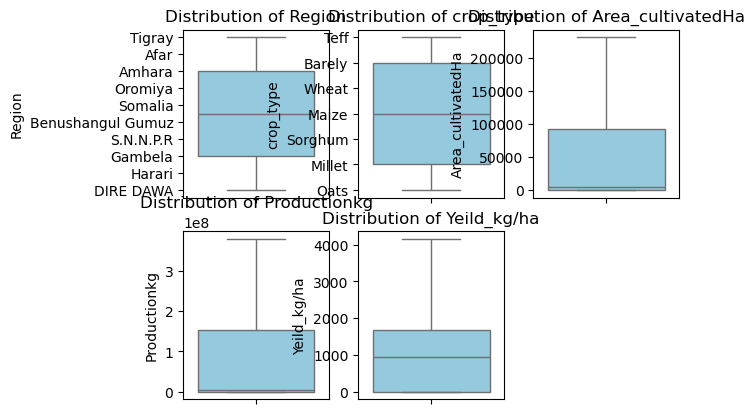

In [15]:
features=['Region', 'crop_type', 'Area_cultivatedHa', 'Productionkg','Yeild_kg/ha']

for i, col in enumerate(features):
    plt.subplot(2,3,i+1)
    sns.boxplot(y=data[col], color='skyblue')
    plt.title(f'Distribution of {col}')


### Check Data Type

In [16]:
data.dtypes

Region                object
crop_type             object
Year                   int64
Area_cultivatedHa    float64
Productionkg         float64
Yeild_kg/ha          float64
dtype: object

### Check Crop Types

In [17]:
data['crop_type'].unique()

array(['Teff', 'Barely', 'Wheat', 'Maize', 'Sorghum', 'Millet', 'Oats'],
      dtype=object)

In [18]:
data.value_counts('crop_type')

crop_type
Barely     260
Maize      260
Millet     260
Oats       260
Sorghum    260
Teff       260
Wheat      260
Name: count, dtype: int64

### Identify  Regions 

In [20]:
data['Region'].unique()

array(['Tigray', 'Afar', 'Amhara', 'Oromiya', 'Somalia',
       'Benushangul Gumuz', 'S.N.N.P.R', 'Gambela', 'Harari', 'DIRE DAWA'],
      dtype=object)

In [21]:
data.value_counts('Region')

Region
Afar                 182
Amhara               182
Benushangul Gumuz    182
DIRE DAWA            182
Gambela              182
Harari               182
Oromiya              182
S.N.N.P.R            182
Somalia              182
Tigray               182
Name: count, dtype: int64

### Rearrange  Data Columns 

In [19]:
data.columns 

Index(['Region', 'crop_type', 'Year', 'Area_cultivatedHa', 'Productionkg',
       'Yeild_kg/ha'],
      dtype='object')

In [20]:
col=['Year','Region', 'crop_type', 'Area_cultivatedHa', 'Productionkg',
       'Yeild_kg/ha']

In [21]:
data=data[col]

In [22]:
data.head()

,Year,Region,crop_type,Area_cultivatedHa,Productionkg,Yeild_kg/ha
0,1996,Tigray,Teff,87880.0,60827000.0,692.0
1,1996,Tigray,Barely,87350.0,81711000.0,935.0
2,1996,Tigray,Wheat,84550.0,84653000.0,1001.0
3,1996,Tigray,Maize,45050.0,67963000.0,1509.0
4,1996,Tigray,Sorghum,96140.0,172968000.0,1799.0


# 3 Data Visualization

## Bar Graph

### Average production by crop type

C:\Users\hp\AppData\Local\Temp\ipykernel_8364\2255195921.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_prod.index, y=avg_prod.values, palette="Spectral")


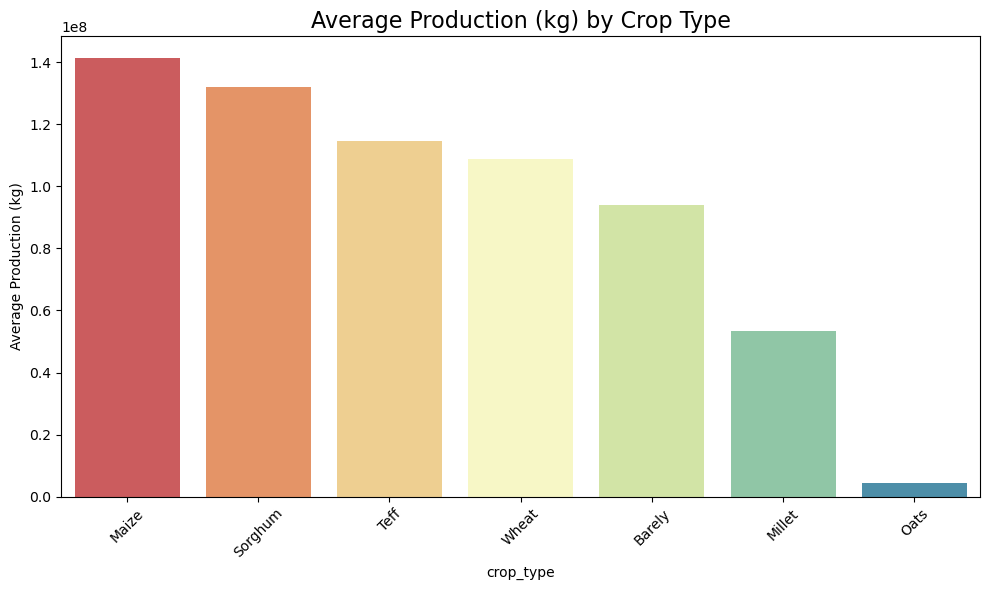

In [26]:
# Calculate average production by crop type
avg_prod = data.groupby('crop_type')['Productionkg'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_prod.index, y=avg_prod.values, palette="Spectral")
plt.xticks(rotation=45)
plt.title("Average Production (kg) by Crop Type", fontsize=16)
plt.ylabel("Average Production (kg)")
plt.xlabel("crop_type")
plt.tight_layout()
plt.show()

### Average yield by crop type

C:\Users\hp\AppData\Local\Temp\ipykernel_14148\4169497070.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_yield_crop.index,y=avg_yield_crop.values,palette="Spectral")


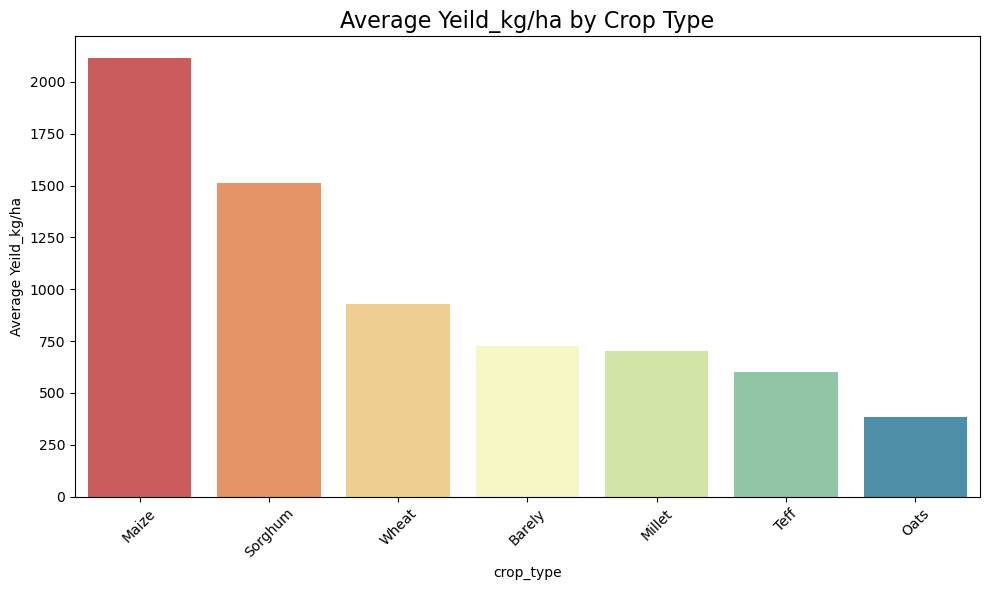

In [29]:
plt.figure(figsize=(10,6))
avg_yield_crop=data.groupby('crop_type')['Yeild_kg/ha'].mean().sort_values(ascending=False)
sns.barplot(x=avg_yield_crop.index,y=avg_yield_crop.values,palette="Spectral")
plt.xticks(rotation=45)
plt.title("Average Yeild_kg/ha by Crop Type", fontsize=16)
plt.ylabel("Average Yeild_kg/ha")
plt.xlabel("crop_type")
plt.tight_layout()
plt.show()

In [30]:
#plt.figure(figsize=(15,10))
#sns.countplot(x=data['crop_type'],palette='deep')
#plt.title('counter plot')
#plt.show()

In [31]:
#plt.figure(figsize=(15,10))
#sns.countplot(y=data['Region'],palette='Spectral')
#plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_14148\3939342884.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_yield_crop.index,y=avg_yield_crop.values,palette='deep')


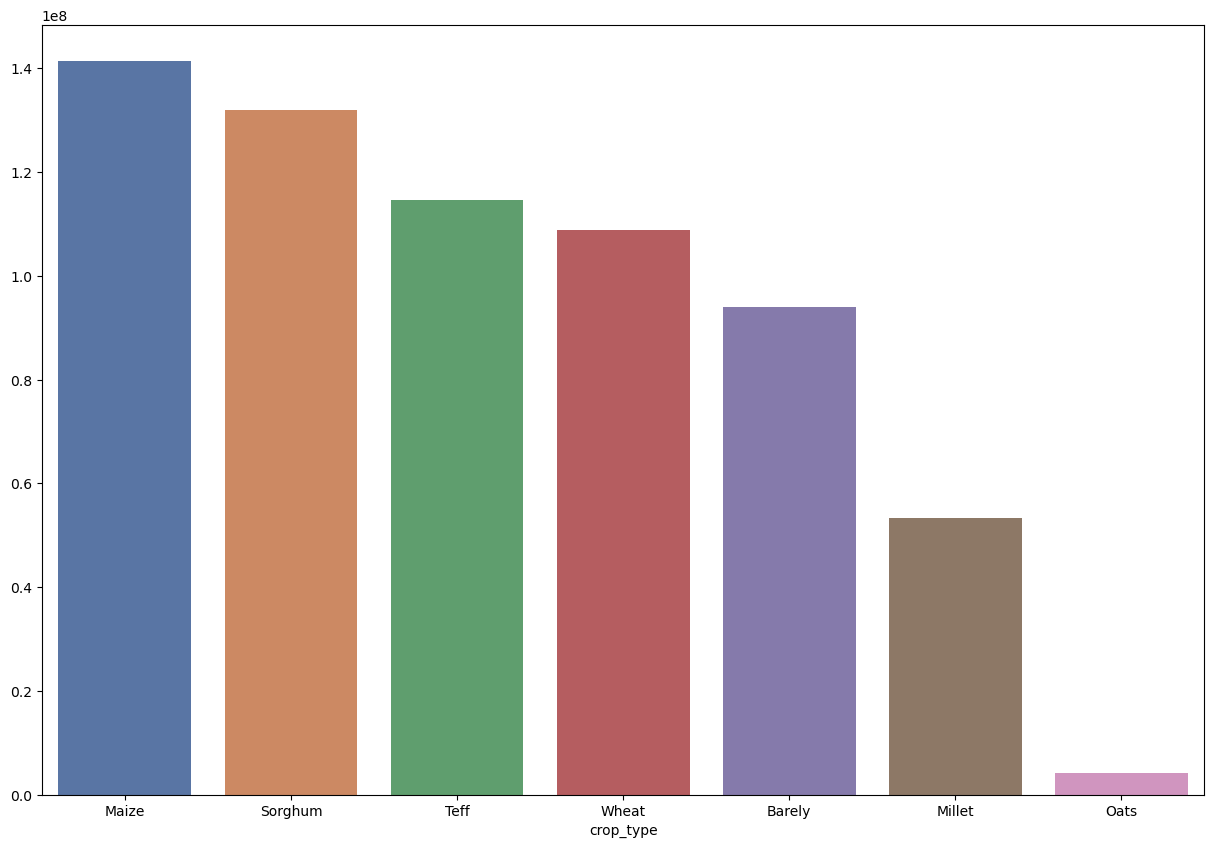

In [32]:
avg_yield_crop=data.groupby('crop_type')['Productionkg'].mean().sort_values(ascending=False)

plt.figure(figsize=(15,10))
sns.barplot(x=avg_yield_crop.index,y=avg_yield_crop.values,palette='deep')
plt.show()

# 4 Data Splitting  For Training and Testing Values

In [ ]:
from sklearn import preprocessing
# Create and store LabelEncoders for Region and crop_type so they can be reused
label_encoders = {}
for col in ['Region', 'crop_type']:
    le = preprocessing.LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le


In [43]:
from sklearn.model_selection import train_test_split

x=data.drop(['Yeild_kg/ha'],axis=1)
y=data['Yeild_kg/ha']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=30,shuffle=True)


In [44]:
data.head()

,Year,Region,crop_type,Area_cultivatedHa,Productionkg,Yeild_kg/ha
0,1996,9,5,87880.0,60827000.0,692.0
1,1996,9,0,87350.0,81711000.0,935.0
2,1996,9,6,84550.0,84653000.0,1001.0
3,1996,9,1,45050.0,67963000.0,1509.0
4,1996,9,4,96140.0,172968000.0,1799.0


In [45]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

ohe=OneHotEncoder(drop='first',sparse_output=False)
scale=StandardScaler()

preprocesser=ColumnTransformer(
    transformers=[
        ('StandardScaler',scale,[0,3,4]), # scaled numerical variable index 0,3,4
        ('OneHotEncoder',ohe,[1,2]) # encode categorical variable index 1 and 2
    ],
    remainder='passthrough'
)



In [46]:
x.head()

,Year,Region,crop_type,Area_cultivatedHa,Productionkg
0,1996,9,5,87880.0,60827000.0
1,1996,9,0,87350.0,81711000.0
2,1996,9,6,84550.0,84653000.0
3,1996,9,1,45050.0,67963000.0
4,1996,9,4,96140.0,172968000.0


In [28]:
y.head()

0     692.0
1     935.0
2    1001.0
3    1509.0
4    1799.0
Name: Yeild_kg/ha, dtype: float64

In [29]:
x_train.head()

,Year,Region,crop_type,Area_cultivatedHa,Productionkg
706,2019,6,3,11212.68,2.467852e+07
1205,2013,7,0,82040.19,1.314680e+08
1106,1998,7,5,123240.00,8.776500e+07
74,2007,9,4,207488.92,3.345063e+08
109,2012,9,4,215142.84,3.790719e+08


In [47]:
x_train=preprocesser.fit_transform(x_train)
# Use transform on x_test to avoid refitting the preprocessor
x_test=preprocesser.transform(x_test)

# Model Building

## Before Model Building which Algorithm is Appropriate Or Good for Our Dataset

### we have different algorithms for regression :
#### LinearRegression,Ridge,Lasso,
#### DecisionTreeRegressor,
#### RandomForestRegressor,
#### XGBRegressor,SVR,
#### KNeighborsRegressor
#### then check by mean square error and R square for which algorithm is most appropriate for the dataset

In [48]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

inputs=data[['Area_cultivatedHa','Productionkg']]

Algorithms = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
}

print("Model Performance (5-fold Cross-Validation):\n")
for names, select in Algorithms.items():
    mse_scores = cross_val_score(select, inputs, y, scoring='neg_mean_squared_error', cv=5)
    r2_scores = cross_val_score(select, inputs, y, scoring='r2', cv=5)
    print(f"{names} => MSE: {-np.mean(mse_scores):.2f}, R²: {np.mean(r2_scores):.2f}")


Model Performance (5-fold Cross-Validation):

LinearRegression => MSE: 748294.99, R²: 0.00
Ridge => MSE: 748294.99, R²: 0.00
Lasso => MSE: 748294.99, R²: 0.00
DecisionTree => MSE: 373102.87, R²: 0.48
RandomForest => MSE: 313978.70, R²: 0.55
RandomForest => MSE: 313978.70, R²: 0.55
XGBoost => MSE: 276248.26, R²: 0.61
XGBoost => MSE: 276248.26, R²: 0.61
SVR => MSE: 1002404.04, R²: -0.34
KNN => MSE: 594479.71, R²: 0.21
SVR => MSE: 1002404.04, R²: -0.34
KNN => MSE: 594479.71, R²: 0.21


#### From the output XGBoost have small MSE and Large R Square ,so this algorithm is better than other 
#### then use these   algorithms for build a model 

In [49]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score


# label_encoders created earlier during preprocessing; reuse them here (no need to refit)
# If you re-run cells out of order and label_encoders is undefined, re-create it using the preprocessing cell above.

models_1={
    #'LinearRegression':LinearRegression(),
   # 'Lasso':Lasso(),
   # 'Ridge':Ridge(),
  # 'RandomForestRegressor':RandomForestRegressor(
                         # n_estimators=100, random_state=42
                         # ),
   ' XGBRegressor':XGBRegressor(
                   n_estimators=100, random_state=42
                  )
    
}

for name,model in models_1.items():
    model.fit(x_train,y_train)
    

In [50]:
from xgboost import XGBRegressor

model=XGBRegressor(
    n_estimators=100,
    random_state=42
)
model.fit(x_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [51]:
data.head()

,Year,Region,crop_type,Area_cultivatedHa,Productionkg,Yeild_kg/ha
0,1996,9,5,87880.0,60827000.0,692.0
1,1996,9,0,87350.0,81711000.0,935.0
2,1996,9,6,84550.0,84653000.0,1001.0
3,1996,9,1,45050.0,67963000.0,1509.0
4,1996,9,4,96140.0,172968000.0,1799.0


# Make Prediction

In [60]:
y_predict=model.predict(x_test)

In [61]:
print(y_predict)

[ 2.52607250e+01  2.42824829e+03  6.26030884e+02  2.16063306e+03
  7.40447205e+02  1.32787927e+03  2.11058838e+03  2.40476953e+03
  1.76190100e+03 -7.74223557e+01 -2.48547421e+01 -1.77339435e+00
  9.58322327e+02  1.23703320e+03  1.84505762e+03  8.38955224e-01
  2.62720386e+03 -1.54088378e+00  6.21140182e-01  3.57827139e+00
  8.95851624e+02 -1.63455236e+00  1.18879883e+03  5.46623474e+02
 -2.74657822e+00  1.32575893e+00 -8.77468967e+00  4.14774365e+03
  8.42109741e+02  2.32843530e+03 -2.74657822e+00  1.71368701e+03
  3.69501831e+03 -4.68270922e+00  1.47745544e+03  3.24136621e+03
  1.45130164e+03  2.35359716e+00  3.10929053e+03 -3.71575475e+00
  1.21138049e+03  5.68292427e+00  1.46503491e+03  1.00522424e+03
  1.95605786e+03  2.25252930e+03 -1.40646946e+00  1.87528564e+03
  8.17534485e+02  3.77448654e+00 -4.73180246e+00 -5.26158619e+00
  6.43405819e+00  1.61082251e+03 -4.63772476e-01  1.04163003e+00
  3.78344029e-01  1.76181299e+03  1.91293750e+03  2.69851929e+03
  7.14057129e+02 -3.06302

In [ ]:
import joblib
joblib.dump(model,'crop_yield_model.pkl')
joblib.dump(preprocesser,'preprocesser.pkl')

['crop_yield_model.pkl']

In [68]:
import joblib
joblib.dump(preprocesser,'preprocesser.pkl')

['preprocesser.pkl']

In [58]:
from sklearn.compose import ColumnTransformer
def prediction(Year, Region, crop_type,  Area_cultivatedHa, Productionkg):
    # Convert Region and crop_type to encoded integers if they are provided as strings
    reg = Region
    crop = crop_type
    # Try primary encoders first; if they were accidentally fit on numeric labels, fall back to raw encoders
    if isinstance(reg, str):
        # first attempt: primary encoder
        try:
            reg = int(label_encoders['Region'].transform([reg])[0])
        except Exception:
            # fallback: try raw_label_encoders (fitted on original CSV strings)
            if 'raw_label_encoders' in globals() and 'Region' in raw_label_encoders:
                reg = int(raw_label_encoders['Region'].transform([reg])[0])
            else:
                raise ValueError('Region value not found in available encoders. Re-create label_encoders from raw data before predicting.')
    if isinstance(crop, str):
        try:
            crop = int(label_encoders['crop_type'].transform([crop])[0])
        except Exception:
            if 'raw_label_encoders' in globals() and 'crop_type' in raw_label_encoders:
                crop = int(raw_label_encoders['crop_type'].transform([crop])[0])
            else:
                raise ValueError('crop_type value not found in available encoders. Re-create label_encoders from raw data before predicting.')
    # Build a DataFrame with the same columns used during training
    features = pd.DataFrame([[Year, reg, crop, Area_cultivatedHa, Productionkg]],
                            columns=['Year','Region','crop_type','Area_cultivatedHa','Productionkg'])
    # Transform and predict
    transform_feature = preprocesser.transform(features)
    predicted_yield = model.predict(transform_feature).reshape(-1,1)
    return float(predicted_yield[0][0])
 

In [59]:
import traceback
try:
    # Call the prediction helper to reproduce the error
    out = prediction(1996, 'Tigray', 'Teff', 87880.0, 60827000)
    print('Prediction output:', out)
except Exception as e:
    print('Exception type:', type(e))
    print('Exception message:', e)
    print('\nFull traceback:')
    traceback.print_exc()

Exception type: <class 'ValueError'>
Exception message: Region value not found in available encoders. Re-create label_encoders from raw data before predicting.

Full traceback:


Traceback (most recent call last):
  File "C:\Users\HP\AppData\Local\Temp\ipykernel_20508\1310196651.py", line 10, in prediction
    reg = int(label_encoders['Region'].transform([reg])[0])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py", line 129, in transform
    y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1454, in column_or_1d
    y = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1051, in check_array
    array = xp.astype(array, dtype, copy=False)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\externals\array_api_compat\numpy\_aliases.py", line 125, in astype
    return x.astype(dtype=dtype, copy=copy)
           ^

# Model Evaluation 

In [46]:
for name,model in models_1.items():
    MSE=mean_squared_error(y_test,y_predict)
    R2=r2_score(y_test,y_predict)
    print(f"{name}, Mean Squar Error is :{MSE}")
    print(f"{name},R Squar is :{R2}")



 XGBRegressor, Mean Squar Error is :164967.6988239214
 XGBRegressor,R Squar is :0.8339269578658841


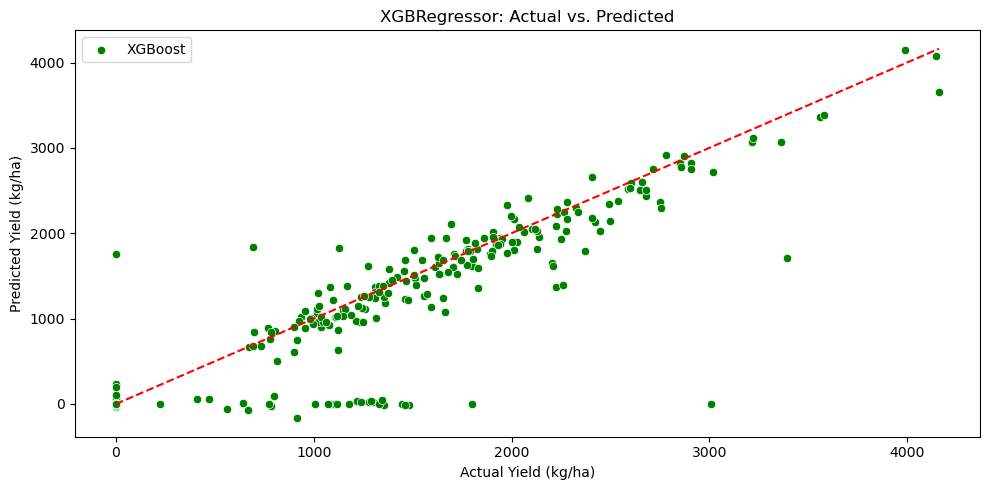

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns


# XGBoost: Actual vs. Predicted
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_predict, color='green', label='XGBoost')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Yield (kg/ha)")
plt.ylabel("Predicted Yield (kg/ha)")
plt.title("XGBRegressor: Actual vs. Predicted")
plt.legend()
plt.tight_layout()
plt.show()


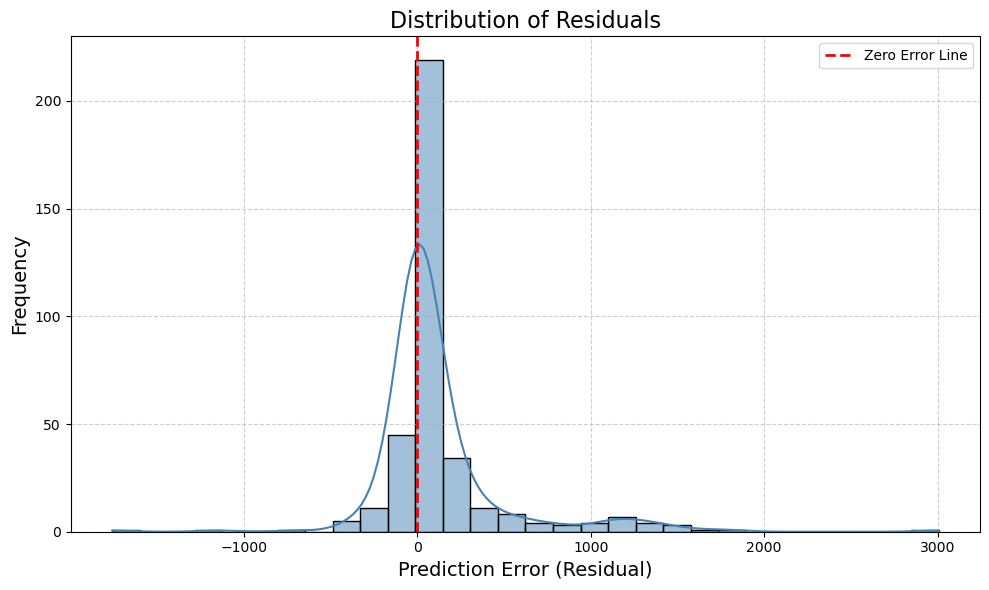

In [48]:
# we have y_test (true values) and y_pred (model predictions)
residuals = y_test - y_predict

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color="steelblue", edgecolor='black')

plt.title("Distribution of Residuals", fontsize=16)
plt.xlabel("Prediction Error (Residual)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error Line')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


##### The distribution is roughly symmetric and looks like a normal (Gaussian) distribution.
##### This is a good sign: it suggests that the model's errors are normally distributed — which is one of the assumptions for many regression models.
##### There are a few residuals on the far left (below -1000) and far right (above 2000).
##### This indicates that while most predictions are close, the model makes some large errors for a few samples.

# Model Deployment

In [49]:
import joblib


# Assuming your trained model is named 'model'
joblib.dump(model, 'yield_model.pkl')
joblib.dump(label_encoders['Region'], "region_encoder.pkl")
joblib.dump(label_encoders['crop_type'], "crop_encoder.pkl")
joblib.dump(preprocesser,'preprocessor.pkl') 

['preprocessor.pkl']

In [51]:
import gradio as gr
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

# === Sample values for dropdowns ===
regions = ['Tigray', 'Afar', 'Amhara', 'Oromiya', 'Somalia', 'Benushangul Gumuz', 'S.N.N.P.R', 'Gambela', 'Harari', 'DIRE DAWA']
crops = ['Teff', 'Barely', 'Wheat', 'Maize', 'Sorghum', 'Millet', 'Oats']


# === Load trained model ===
joblib.load('yield_model.pkl')  # Update with correct model path
joblib.load("region_encoder.pkl")
joblib.load("crop_encoder.pkl")
joblib.load('preprocessor.pkl') 
# === Prediction function ===
def predict_yield(year, region, crop, area, production):
    row = np.array([[year, region, crop, area, production]])
    row_df = pd.DataFrame(row, columns=['Year', 'Region', 'crop_type', 'Area_cultivatedHa', 'Productionkg'])
    row_transformed = preprocesser.transform(row_df)
    pred = model.predict(row_transformed)
    return f" Predicted Yield: {pred[0]:.2f} kg/ha"

# === Gradio Interface ===
gr.Interface(
    fn=predict_yield,
    inputs=[
        gr.Number(label="Year", value=2023),
        gr.Dropdown(choices=regions, label="Region"),
        gr.Dropdown(choices=crops, label="Crop Type"),
        gr.Number(label="Area Cultivated (Ha)"),
        gr.Number(label="Production (kg)")
    ],
    outputs="text",
    title=" Ethiopian Crop Yield Predictor",
    description="Predicts yield (kg/ha) based on region, crop type, cultivated area, and production volume.",
).launch(share=True)


* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://b77d9320d2cf582e88.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
